# Does ambulance travel time to hospital affect survival of haemorrhagic stroke patients? Replicating RACECAT.

Could increased time to arrival at first hospital affect survival rates for haemorrhagic stroke patients?

RACECAT trial suggested a possible effect. See:

Ramos-Pachón, Anna, David Rodríguez-Luna, Joan Martí-Fàbregas, Mònica Millán, Alejandro Bustamante, Marina Martínez-Sánchez, Joaquín Serena, et al. ‘Effect of Bypassing the Closest Stroke Center in Patients with Intracerebral Hemorrhage: A Secondary Analysis of the RACECAT Randomized Clinical Trial’. JAMA Neurology 80, no. 10 (1 October 2023): 1028–36. https://doi.org/10.1001/jamaneurol.2023.2754.

The inclusion criteria for RACECAT were:

* No significant prior-stroke disability (mRS 0-2)
* Suspected LVO (RACE 5+; equivalent to NIHSS 11+)
* Expected arrival at treatment centre of within 7 hours of stroke onset

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np

# Set maximum number of rows and columns to display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
data = pd.read_csv('./../data/data_for_models.csv', low_memory=False)
# Delete columns that are not needed
cols = [
    'id',
    'month',
    'year',
    'weekday']

#data = data.drop(cols, axis=1)


In [7]:
# Loop through columns and check correlation with death (report if P<0.05)
for col in data.columns:
    X = data[col]
    y = data['death']
    selected_data = pd.DataFrame(data[[col, 'death']])
    

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    p = model.pvalues[1]
    if p < 0.05:
        print(f'{col}: {p}')
        print(model.summary())


SyntaxError: '(' was never closed (1695908979.py, line 5)

In [9]:
# Get haemorrhagic stroke data
data = data[data['infarction'] == 0]

# Limit to prior_disability 0-2
data = data[data['prior_disability'] < 3]

# Only use onset to admission of > 0 mins (avoid in-hospital stroke)
data = data[data['onset_to_arrival_time'] > 0]

# Limit to 7 hour arrivals (as RACECAT inclusion criteria)
data = data[data['onset_to_arrival_time'] < 420]

# Use only data where ambulance_travel_to_hospital_time is known (>0)
data = data[data['ambulance_travel_to_hospital_time'] > 0]

# Limit to NIHSS 11+ (equivalent to RACE 5+)
data = data[data['stroke_severity'] > 10]

In [ ]:
# Check signficane of correlation of all features with death
# Get correlation matrix
correlation_matrix = data.corr()
correlation_matrix = correlation_matrix['death']
correlation_matrix = correlation_matrix.sort_values(ascending=False)
print(correlation_matrix)


## Ambulance to hospital travel time

In [10]:
# Get selected data
fields = ['age',
          'male',
          'stroke_severity',
          'ambulance_travel_to_hospital_time',
          'prior_disability',
          'death']

# Get data
selected_data = data[fields]
selected_data = selected_data.dropna()

# Show data
selected_data.describe().T


,count,mean,std,min,25%,50%,75%,max
age,2509.0,75.451375,12.378920,37.5,67.5,77.5,82.5,92.5
male,2509.0,0.504982,0.500075,0.0,0.0,1.0,1.0,1.0
stroke_severity,2509.0,20.905939,7.455765,11.0,15.0,19.0,25.0,42.0
ambulance_travel_to_hospital_time,2509.0,16.581905,9.696355,1.0,9.0,14.0,22.0,73.0
prior_disability,2509.0,0.545237,0.764054,0.0,0.0,0.0,1.0,2.0
death,2509.0,0.615783,0.486507,0.0,0.0,1.0,1.0,1.0


In [12]:
# Split into X and Y
X = selected_data.drop('death', axis=1)
y = selected_data['death']

# Fit a statsmodels logistic regression to death
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.512714
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                 2509
Model:                          Logit   Df Residuals:                     2503
Method:                           MLE   Df Model:                            5
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                  0.2303
Time:                        10:46:18   Log-Likelihood:                -1286.4
converged:                       True   LL-Null:                       -1671.2
Covariance Type:            nonrobust   LLR p-value:                4.261e-164
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -7.6189      0.409    -18

## Refit to model just on ambulance travel to hospital time

Do not adjust for other factors

In [13]:
# Get selected data
fields = ['ambulance_travel_to_hospital_time', 'death']

# Get data
selected_data = data[fields]
selected_data = selected_data.dropna()

# Split into X and Y
X = selected_data.drop('death', axis=1)
y = selected_data['death'].astype(int)

# Fit a statsmodels logistic regression to death
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.664713
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                 2509
Model:                          Logit   Df Residuals:                     2507
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                0.002069
Time:                        10:51:13   Log-Likelihood:                -1667.8
converged:                       True   LL-Null:                       -1671.2
Covariance Type:            nonrobust   LLR p-value:                  0.008547
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.2858      0.082      3

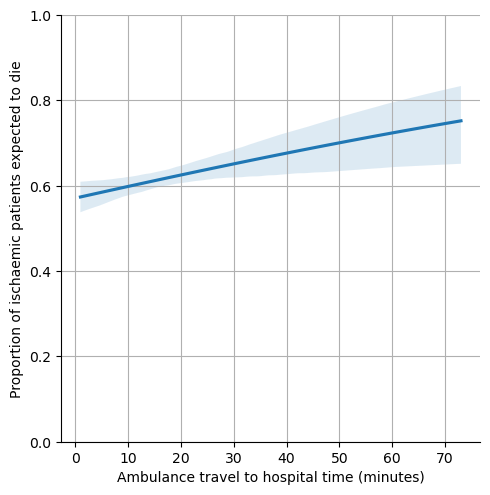

In [14]:
fig = sns.lmplot(x="ambulance_travel_to_hospital_time", y="death", data=data, markers='', logistic=True);
fig.set_xlabels('Ambulance travel to hospital time (minutes)')
fig.set_ylabels('Proportion of ischaemic patients expected to die')
plt.grid()
plt.ylim(0, 1)
plt.show();


With points:

(For linear regression use regplot: https://seaborn.pydata.org/generated/seaborn.regplot.html)

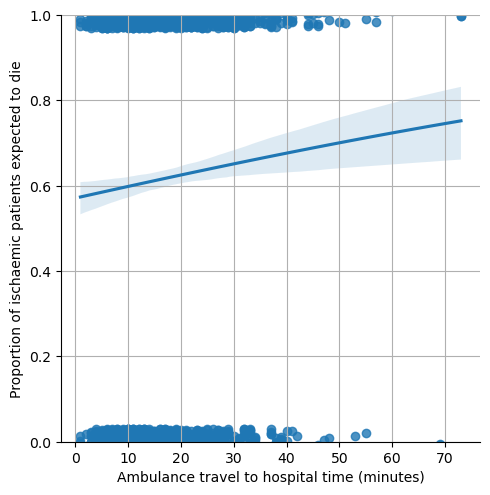

In [15]:
fig = sns.lmplot(x="ambulance_travel_to_hospital_time", y="death", 
                 data=data, markers='o', logistic=True, x_jitter=0, y_jitter=0.03);
fig.set_xlabels('Ambulance travel to hospital time (minutes)')
fig.set_ylabels('Proportion of ischaemic patients expected to die')
plt.grid()
plt.ylim(0, 1)
plt.show();